In [1]:
%matplotlib inline
%store -r
from time import time
from math import sqrt, floor
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support as score
from time import time
from sklearn.metrics import log_loss, accuracy_score
import pandas as pd
from multiprocessing.dummy import Pool as ThreadPool 
from IPython.core.debugger import set_trace
import pickle
import os
from rfc import RandomForest
pd.options.display.float_format = '{:.3f}'.format

import matplotlib.pyplot as plt
plt.style.use = "default"

In [2]:
train = pd.read_csv("cleaned_testData1.csv")
labels = pd.read_csv("cleaned_trainLabel1.csv")

In [3]:
train = train.drop(train.columns[0], axis=1)
labels = labels.drop(labels.columns[0], axis=1)

In [4]:
train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160
count,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,...,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000
mean,1.513,1.204,1.262,1.888,1.390,1.668,1.305,1.743,2.567,1.913,...,1.562,2.009,1.751,2.210,2.285,2.707,2.787,1.225,1.920,2.801
std,0.410,0.404,0.437,0.342,0.460,0.560,0.370,0.333,0.119,0.209,...,0.446,0.163,0.298,0.124,0.199,0.142,0.171,0.369,0.294,0.134
min,1.000,1.000,1.000,1.257,1.000,1.000,1.000,1.000,2.349,1.343,...,1.000,1.651,1.000,1.894,1.829,2.389,2.391,1.000,1.483,2.493
25%,1.231,1.000,1.000,1.676,1.000,1.315,1.000,1.586,2.493,1.793,...,1.031,1.897,1.583,2.114,2.154,2.599,2.678,1.000,1.758,2.727
50%,1.475,1.000,1.000,1.839,1.252,1.652,1.198,1.727,2.549,1.896,...,1.597,2.005,1.723,2.197,2.262,2.707,2.785,1.000,1.863,2.780
75%,1.659,1.204,1.361,2.026,1.570,1.842,1.455,1.853,2.609,1.996,...,1.872,2.103,1.866,2.283,2.386,2.798,2.897,1.327,1.955,2.847
max,3.027,2.713,2.862,2.984,2.754,3.507,2.306,2.760,2.986,2.573,...,2.658,2.861,2.856,2.579,2.945,3.285,3.274,2.728,3.050,3.263


In [5]:
labels.describe()

,label
count,149.000
mean,1.604
std,1.096
min,1.000
25%,1.000
50%,1.000
75%,2.000
max,5.000


In [6]:
def merge(df, labels):
    return labels.merge(df, left_index=True,right_index=True)

In [7]:
def mprint(*args):
    for arg in args:
        print(arg)
        print(" ")

---  

# Model Building

## Which algorithm to use?
We'll use a **random forest classifier** (rfc) with bootstrapping and feature bagging optimizations because:
- ease of implementation
- rfcs handle multi-class predictions well without more additional effort
- works well with high dimensional data
- we'll choose use random forest as opposed to boosted trees since we have highly dimensional data
- with a reasonably high probability, can be used with the other datasets for this project since the algorithm is very robust

## The Algorithm
We'll use the CART algorithm for splitting since we have continuous data.  
  
[Full example](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/)  
  
Steps:
1. Initialize Tree
2. For each column, calc best split across all rows based using gini impurity score - [exmplanation](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) | [exmaple](https://www.researchgate.net/post/How_to_compute_impurity_using_Gini_Index) | [useful blog](http://dni-institute.in/blogs/cart-algorithm-for-decision-tree/)
3. Split the dataset based on the split condition with the highest gini score and add both sets as leaves on a tree node. The node represents a decision point, that being the condition with the highest gini score.
3. Repeat 2 & 3 until an arbitrary minimum number of rows are left
4. Prune tree

ideas:
- instead of using the raw values, categorize the numbers as # of stds away from mean
- > Alternatively, the random forest can apply weight concept for considering the impact of result from any decision tree. Tree with high error rate are given low weight value and vise versa. This would increase the decision impact of trees with low error rate - [medium post](https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1)
- [parameters to  tune](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
- https://stats.stackexchange.com/questions/260460/optimization-of-a-random-forest-model
- https://followthedata.wordpress.com/2012/06/02/practical-advice-for-machine-learning-bias-variance/
- https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

---  
# Model Training & Tuning
## Context
Now that we have our classifier, let's think about how we're going to train the model. 

We'll also measure performance through [precision](https://en.wikipedia.org/wiki/Precision_and_recall) & [recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) - it tells us, for each class, how well the model identifies all cases of that class (recall) and how well it can correctly classify those cases (precision). From wikipedia:
> Suppose a computer program for recognizing dogs in photographs identifies eight dogs in a picture containing 12 dogs and some cats. Of the eight dogs identified, five actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

![precision & recall formulas](https://cdn-images-1.medium.com/max/2000/1*6NkN_LINs2erxgVJ9rkpUA.png)
We can use the [f1 score](https://en.wikipedia.org/wiki/F1_score) to maximize precision and recall when testing different models.  
![f1 score formula](https://cdn-images-1.medium.com/max/1600/1*UJxVqLnbSj42eRhasKeLOA.png)

Recall and precision seem to be very related to bias and variance of the model, so we can maximize the f1 score by tuning the model to affect these.
#### Minimizing bias
- use new/different features
- increase the size of the trees (increases variance)
- increase the number of trees in the forest

#### Minimizing variance
- decrease the number of features
    + probably want to aim to features that are correlated and/or collapse the overall number of features through PCA
- use more data for each tree  

  
Beware: too much completixy is bad & not enough complexity is also bad  
![bias variance tradeoff](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)  
  

#### Stability
We need to make sure to train the classifier on as many data points as possible while also leaving enough to test to reliably tell how well the classifier actually performs. We'll use [k-fold cross validation](https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/):  
  
> 1. Randomly split your entire dataset into k ”folds”.
2. For each k folds in your dataset, build your model on k – 1 folds of the data set. Then, test the model to check the effectiveness for kth fold.
3. Record the error you see on each of the predictions.
4. Repeat this until each of the k folds has served as the test set.

## Procedure
1. Record and save an input configuration for the random forest
1. Separate data into k folds
2. For each fold *k*: 
    1. train the classifier on k-1 folds
    2. predict the k-th fold
    3. measure the: accuracy, [logarithmic](http://wiki.fast.ai/index.php/Log_Loss) [loss](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234#f217), recall, precision, and f1-score
3. Record the performance measures & associate it with the input configuration
3. Evaluate the overall performance difference across all configurations
4. Change variables from the input configuration that optimizes model perfomance & repeat steps 1-5

In [8]:
class Experiment:
    def __init__(self, df, labels, model_class, model_config_names, model_config_init_values, k_folds=10):        
        self.data = df
        self.labels = labels
        self.label_values = labels["label"].unique()
        self.model_class = model_class
        self.model_config_names = model_config_names
        
        self.trial_num = 1
        self.init_experiments(model_config_names, model_config_init_values)
        
        self.k_folds = k_folds
    
    def tweak(self, parameter, new_value):
        self.experiments.loc[len(self.experiments) - 1][parameter] = new_value
        return self
    
    def run_trial(self):
        exp_num = self.experiments.shape[0]
        mprint("Running trail #{}\n------------------------------------".format(exp_num))

        performance_results = []
        folds, labels = self.split_k_folds()
        
        config = self.current_model_config()
        labels = pd.DataFrame(labels)
        
        for i, test_train in enumerate(folds):
            mprint(
                "*************************",
                "Running fold {} of {}".format(i+1, self.k_folds),
                "*************************"
            )
            
            model = self.model()
            t1 = time()
            model.train(test_train[1], pd.DataFrame(labels), *config)
            mprint("fold {} took {}s".format(i+1, time() - t1))
            performance = self.measure_performance(model, merge(test_train[0], labels), self.label_values)
            
            self.record_trial(performance, test_train[1], test_train[0], i+1 == len(folds))
        
        self.trial_num += 1
        self.experiments.loc[len(self.experiments) - 1]["trial_num"] = self.trial_num
        return self.trial_results()
        
    def trial_results(self, trial_num=None):
        if trial_num == None:
            trial_num = self.experiments["trial_num"].max() - 1
        
        return self.experiments[self.experiments["trial_num"] == trial_num], self.experiment_data[int(trial_num)]    

#<--------  PRIVATE METHODS -------->
    def current_trial(self):
        return self.get_trial("current", "latest")
    
    def current_model_config(self):
        return self.experiments.loc[len(self.experiments) - 1][self.model_config_names].astype("int32").values
    
    def get_trial(self, trial_num=None, trial_instance=None):
        if trial_num == "current":
            if trial_instance == None:
                return self.experiments[self.experiments["trial_num"] == self.experiments["trial_num"].max()]
            elif trial_instance == "latest":
                latest = self.experiments[self.experiments["trial_num"] == self.experiments["trial_num"].max()]
                return latest.loc[len(latest) - 1]
        elif trial_num == "prev":
            if trial_instance != None:
                return self.experiment[self.experiments["trial_num"].max() - 1].iloc[trial_instance]
            else:
                return self.experiment[self.experiments["trial_num"].max() - 1]
        elif trial_num == None:
            return self.experiments[self.experiments["trial_num"] == self.experiments["trial_num"].max()]
        else:
            return self.experiments[self.experiments["trial_num"] == trial_num]
        
    def prev_trial(self):
        return self.get_trial("prev")
    
    def trial_data(self, trial_num=None):
        if trial_num == None:
            trial_num = self.experiments["trial_num"].max()-1
        
        return self.experiment_data[trial_num]
    
    def model(self):
        return self.model_class(verbose=False)
    
    def init_experiments(self, config_names, config_values):
        derived_cols = self.performance_measures() + ["trial_num"]
        all_cols = config_names + derived_cols
        first_row = config_values + [np.nan for i in derived_cols]
        
        self.experiments = pd.DataFrame(columns=all_cols)
        self.experiments.loc[0] = first_row
        self.experiments.loc[0]["trial_num"] = self.trial_num
        self.experiments[config_names] = self.experiments[config_names].fillna(-1)
        self.experiment_data = []
    
    def record_trial(self, results, train, test, final=False):
        for key in results:
            self.experiments.loc[len(self.experiments) - 1][key] = results[key]

        self.experiments.loc[len(self.experiments)] = self.experiments.loc[len(self.experiments) - 1]
        self.experiment_data.append((train, test))
            
    def performance_measures(self):
        return ["log_loss", "class_accuracy", "precision", "recall", "f1-score", "support"]
    
    def split_k_folds(self):
        splitter = int(np.ceil(self.data.shape[0] / self.k_folds))
        df = shuffle(merge(self.data, self.labels))
        labels = df.pop("label")

        folds = []
        for i in range(1, self.k_folds+1):
            train = df.iloc[(i-1) * splitter: i * splitter]
            test = df.iloc[np.r_[0:(i-1) * splitter, i*splitter: df.shape[0]]]
            folds.append((train, test))

        return folds, labels
    
    def measure_performance(self, model, test_set, label_values=None):
        test_labels = test_set.pop("label")
        if label_values is None:
            label_values = test_labels.unique()

        predictions = test_set.apply(lambda row: model.predict(row), axis=1)
        precision, recall, fscore, support = score(test_labels, predictions, average='weighted')

        lvs = [[1 if p == 1 else 0 for l in label_values] for p in predictions]
        return {
            "log_loss" : log_loss(test_labels, lvs, normalize=True, labels=label_values),
            "class_accuracy": accuracy_score(test_labels, predictions, normalize=True),
            "precision": precision,
            "recall": recall,
            "f1-score": fscore,
            "support": support
        }

In [9]:
init_config_names = ["num_trees", "num_features", "num_sample_rows", "max_tree_depth", "min_split_samples"]
init_config_values = [   10,          None,           None,              20,                5] # default settings = initial settings

e = Experiment(train, labels, RandomForest, init_config_names, init_config_values)

In [83]:
e.current_model_config()

array([10, -1, -1, 20,  5], dtype=int32)

In [10]:
e.run_trial()
%store e

Running trail #1
------------------------------------
 
*************************
 
Running fold 1 of 10
 
*************************
 
fold 1 took 21.575438976287842s
 
*************************
 
Running fold 2 of 10
 
*************************
 


/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fold 2 took 17.12821912765503s
 
*************************
 
Running fold 3 of 10
 
*************************
 
fold 3 took 19.819180011749268s
 
*************************
 
Running fold 4 of 10
 
*************************
 
fold 4 took 19.02623200416565s
 
*************************
 
Running fold 5 of 10
 
*************************
 
fold 5 took 23.62216305732727s
 
*************************
 
Running fold 6 of 10
 
*************************
 
fold 6 took 17.78378915786743s
 
*************************
 
Running fold 7 of 10
 
*************************
 
fold 7 took 18.721735954284668s
 
*************************
 
Running fold 8 of 10
 
*************************
 
fold 8 took 22.229801893234253s
 
*************************
 
Running fold 9 of 10
 
*************************
 
fold 9 took 19.35861110687256s
 
*************************
 
Running fold 10 of 10
 
*************************
 
fold 10 took 28.434226989746094s
 
Proper storage of interactively declared classes (or instances
of

In [11]:
perf, train_test = e.trial_results()

In [20]:
e.experiments

,num_trees,num_features,num_sample_rows,max_tree_depth,min_split_samples,log_loss,class_accuracy,precision,recall,f1-score,support,trial_num
0,10.000,-1.000,-1.000,20.000,5.000,1.609,0.867,0.751,0.867,0.805,nan,1.000
1,10.000,-1.000,-1.000,20.000,5.000,1.609,0.733,0.538,0.733,0.621,nan,1.000
2,10.000,-1.000,-1.000,20.000,5.000,1.609,0.667,0.444,0.667,0.533,nan,1.000
3,10.000,-1.000,-1.000,20.000,5.000,1.609,0.800,0.640,0.800,0.711,nan,1.000
4,10.000,-1.000,-1.000,20.000,5.000,1.609,0.800,0.640,0.800,0.711,nan,1.000
5,10.000,-1.000,-1.000,20.000,5.000,1.609,0.400,0.160,0.400,0.229,nan,1.000
6,10.000,-1.000,-1.000,20.000,5.000,1.609,0.667,0.444,0.667,0.533,nan,1.000
7,10.000,-1.000,-1.000,20.000,5.000,1.609,0.733,0.538,0.733,0.621,nan,1.000
8,10.000,-1.000,-1.000,20.000,5.000,1.609,0.667,0.444,0.667,0.533,nan,1.000
9,10.000,-1.000,-1.000,20.000,5.000,1.609,0.857,0.735,0.857,0.791,nan,1.000


## Trial 1 Notes:

These settings were default. Since we have 5 classes, the range of log loss is between 0 and 1.6, meaning our log loss is pretty bad and that we're very likely to misclassify. The accuracy seems good, but that's only because class 1 has a higher chance to appear in general as it appears ~70% of the time. As we see in iteration 7, accuracy and precision are _.533_ and _.284_  respectively. That iteration probably had more diverse labels than usual, but the model only got it right $\frac{1}{4}^{th}%$ of the time. 

In [13]:
t_7_train, t_7_test  = e.experiment_data[6]

t_7_train_g = merge(t_7_train, labels).groupby("label")
t_7_test_g = merge(t_7_test, labels).groupby("label")

In [14]:
t_7_train_g.count().apply(lambda x: x / t_7_train.shape[0]).T.iloc[0]

label
1   0.724
2   0.097
3   0.052
4   0.104
5   0.022
Name: f0, dtype: float64

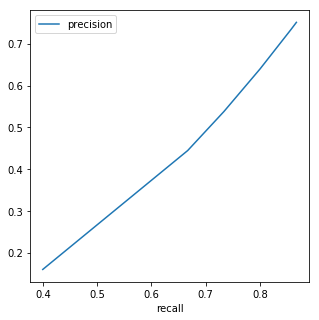

In [15]:
e.experiments.sort_values(["recall", "precision"]).plot("recall", "precision", "line", figsize=(5,5))

Very odd that precision and recall move in step.. Not sure what that means.

In [16]:
e.experiments[e.performance_measures()].mean()

log_loss         1.609
class_accuracy   0.732
precision        0.552
recall           0.732
f1-score         0.625
support            nan
dtype: float64

Overall, it seems like the classifier is stuck on the imbalance of classes in the dataset. We have close to 0 variance but lots of bias. To combat this, we'll add more & deeper trees in hopes that the model will pick up on more variance, train some trees only on data that have the imbalanced classes, and use less data to train the model with in order to reduce the extent to which a single class and dominate the others.

In [26]:
e.tweak("num_trees", 15).tweak("min_split_samples", 2).tweak("num_features", 12)

In [28]:
e.run_trial()
%store e

Running trail #11
------------------------------------
 
*************************
 
Running fold 1 of 10
 
*************************
 
fold 1 took 43.15527701377869s
 
*************************
 
Running fold 2 of 10
 
*************************
 


/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fold 2 took 41.536792039871216s
 
*************************
 
Running fold 3 of 10
 
*************************
 
fold 3 took 47.262762784957886s
 
*************************
 
Running fold 4 of 10
 
*************************
 
fold 4 took 56.707643032073975s
 
*************************
 
Running fold 5 of 10
 
*************************
 
fold 5 took 43.702346086502075s
 
*************************
 
Running fold 6 of 10
 
*************************
 
fold 6 took 47.30037593841553s
 
*************************
 
Running fold 7 of 10
 
*************************
 
fold 7 took 29.99281096458435s
 
*************************
 
Running fold 8 of 10
 
*************************
 
fold 8 took 47.83272194862366s
 
*************************
 
Running fold 9 of 10
 
*************************
 
fold 9 took 42.6654269695282s
 
*************************
 
Running fold 10 of 10
 
*************************
 
fold 10 took 40.48732113838196s
 
Proper storage of interactively declared classes (or instances
of 

In [30]:
t2_results, t2_train_test =  e.trial_results()

In [33]:
t2_results

,num_trees,num_features,num_sample_rows,max_tree_depth,min_split_samples,log_loss,class_accuracy,precision,recall,f1-score,support,trial_num
10,15.000,12.000,-1.000,20.000,2.000,1.609,0.733,0.538,0.733,0.621,nan,2.000
11,15.000,12.000,-1.000,20.000,2.000,1.609,0.800,0.640,0.800,0.711,nan,2.000
12,15.000,12.000,-1.000,20.000,2.000,1.609,0.733,0.538,0.733,0.621,nan,2.000
13,15.000,12.000,-1.000,20.000,2.000,1.609,0.533,0.284,0.533,0.371,nan,2.000
14,15.000,12.000,-1.000,20.000,2.000,1.609,0.733,0.538,0.733,0.621,nan,2.000
15,15.000,12.000,-1.000,20.000,2.000,1.609,0.733,0.538,0.733,0.621,nan,2.000
16,15.000,12.000,-1.000,20.000,2.000,1.609,0.800,0.640,0.800,0.711,nan,2.000
17,15.000,12.000,-1.000,20.000,2.000,1.609,0.533,0.284,0.533,0.371,nan,2.000
18,15.000,12.000,-1.000,20.000,2.000,1.609,0.800,0.640,0.800,0.711,nan,2.000
19,15.000,12.000,-1.000,20.000,2.000,1.609,0.786,0.617,0.786,0.691,nan,2.000


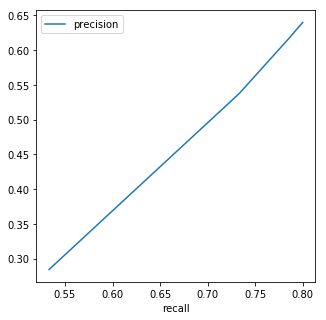

In [34]:
t2_results.sort_values(["recall", "precision"]).plot("recall", "precision", "line", figsize=(5,5))

## Trial 2 Notes:
Welp - that didn't work.